In [39]:
import pandas as pd
import re

# Load and inspect the data
df = pd.read_csv('C:\\Users\\Kamal\\Downloads\\final_translation.csv')
df.columns = ['English', 'Tamil']
df.info()

# Function to clean text (removes unwanted characters)
def clean_text(text):
    return re.sub(r'[^a-zA-Z0-9\u0B80-\u0BFF\s]', '', text)

# Clean English and Tamil columns
df['English'] = df['English'].apply(clean_text)
df['Tamil'] = df['Tamil'].apply(clean_text)

# Function to check if Tamil text contains English characters
def contains_english(text):
    return bool(re.search(r'[a-zA-Z]', text))

# Filter out rows where Tamil text contains English words
df = df[~df['Tamil'].apply(contains_english)]

# WordLevelTokenizer class definition
class WordLevelTokenizer:
    def __init__(self, special_tokens=None):
        self.word_to_id = {}
        self.id_to_word = {}
        self.special_tokens = special_tokens or []
        self.build_vocab(self.special_tokens)

    def build_vocab(self, tokens):
        for token in tokens:
            self.add_token(token)

    def add_token(self, token):
        if token not in self.word_to_id:
            idx = len(self.word_to_id)
            self.word_to_id[token] = idx
            self.id_to_word[idx] = token

    def tokenize(self, text):
        return text.split()

    def encode(self, text):
        tokens = self.tokenize(text)
        return [self.word_to_id.get(token, self.word_to_id.get("<UNK>")) for token in tokens]

    def decode(self, token_ids):
        return " ".join(self.id_to_word.get(idx, "<UNK>") for idx in token_ids)

    def fit_on_texts(self, texts):
        for text in texts:
            tokens = self.tokenize(text)
            self.build_vocab(tokens)

    def vocab_size(self):
        return len(self.word_to_id)

# Initialize tokenizers with special tokens
special_tokens = ["<UNK>", "<PAD>", "<SOS>", "<EOS>"]
tamil_tokenizer = WordLevelTokenizer(special_tokens=special_tokens)
english_tokenizer = WordLevelTokenizer(special_tokens=special_tokens)

# Fit tokenizers on the respective text columns
tamil_tokenizer.fit_on_texts(df['Tamil'])
print("Tamil Vocabulary Size:", len(tamil_tokenizer.word_to_id))

english_tokenizer.fit_on_texts(df['English'])
print("English Vocabulary Size:", len(english_tokenizer.word_to_id))

# Tokenize the text in both English and Tamil columns
df['Tokenized_Tamil'] = df['Tamil'].apply(lambda x: tamil_tokenizer.encode(x))
df['Tokenized_English'] = df['English'].apply(lambda x: english_tokenizer.encode(x))

# Remove rows with long sequences (more than 24 tokens) in Tamil or English columns
df = df[df['Tokenized_Tamil'].apply(len) <= 24]
df = df[df['Tokenized_English'].apply(len) <= 24]

# Reset the index after removing rows
df = df.reset_index(drop=True)

# Final dataframe inspection
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11104 entries, 0 to 11103
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   English  11104 non-null  object
 1   Tamil    11104 non-null  object
dtypes: object(2)
memory usage: 173.6+ KB
Tamil Vocabulary Size: 15529
English Vocabulary Size: 8100
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11037 entries, 0 to 11036
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   English            11037 non-null  object
 1   Tamil              11037 non-null  object
 2   Tokenized_Tamil    11037 non-null  object
 3   Tokenized_English  11037 non-null  object
dtypes: object(4)
memory usage: 345.0+ KB


In [40]:
import numpy as np

# Example of the maximum padding length
max_pad = 24
cls_token = 2
sep_token = 3

# Function to pad sequences
def pad_sequence_source(tokens, max_len, cls_token=2,sep_token = 3):
    # Add the cls token at the beginning
    padded_tokens = [cls_token] + tokens + [sep_token]
    #padded_tokens = padded_tokens + [sep_token]

    # Pad the sequence if it's shorter than max_len
    if len(padded_tokens) < max_len:
        padded_tokens.extend([1] * (max_len - len(padded_tokens)))
    # Truncate if it's longer than max_len
    else:
        padded_tokens = padded_tokens[:max_len]

    return padded_tokens

def pad_sequence_target(tokens, max_len, cls_token = 2):
    # Add the cls token at the beginning
    padded_tokens = [cls_token] + tokens

    # Pad the sequence if it's shorter than max_len
    if len(padded_tokens) < max_len:
        padded_tokens.extend([1] * (max_len - len(padded_tokens)))
    # Truncate if it's longer than max_len
    else:
        padded_tokens = padded_tokens[:max_len]

    return padded_tokens

def pad_sequence_label(tokens, max_len, sep_token = 3):
    # Add the cls token at the beginning
    padded_tokens = tokens + [sep_token]

    # Pad the sequence if it's shorter than max_len
    if len(padded_tokens) < max_len:
        padded_tokens.extend([1] * (max_len - len(padded_tokens)))
    # Truncate if it's longer than max_len
    else:
        padded_tokens = padded_tokens[:max_len]

    return padded_tokens

# Apply padding and add CLS token to both English and Tamil columns
df['Padded_English'] = df['Tokenized_English'].apply(lambda x: pad_sequence_source(x, max_pad, cls_token,sep_token))
df['Padded_Tamil'] = df['Tokenized_Tamil'].apply(lambda x: pad_sequence_target(x, max_pad, cls_token))
df['Padded_Tamil_Target'] = df['Tokenized_Tamil'].apply(lambda x: pad_sequence_label(x, max_pad,sep_token))
# Verify the result
#print(df[['Padded_English', 'Padded_Tamil','Padded_Tamil_Target']].head(-10))
df

,English,Tamil,Tokenized_Tamil,Tokenized_English,Padded_English,Padded_Tamil,Padded_Tamil_Target
0,Lets try something,ஏதாவது முயற்சி செய்யலாம்,"[4, 5, 6]","[4, 5, 6]","[2, 4, 5, 6, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 4, 5, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[4, 5, 6, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,I have to go to sleep,நான் தூங்க செல்ல வேண்டும்,"[7, 8, 9, 10]","[7, 8, 9, 10, 9, 11]","[2, 7, 8, 9, 10, 9, 11, 3, 1, 1, 1, 1, 1, 1, 1...","[2, 7, 8, 9, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[7, 8, 9, 10, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
2,Today is June 18th and it is Muiriels birthday,இன்று ஜூன் 18 மற்றும் முரியலின் பிறந்த நாள்,"[11, 12, 13, 14, 15, 16, 17]","[12, 13, 14, 15, 16, 17, 13, 18, 19]","[2, 12, 13, 14, 15, 16, 17, 13, 18, 19, 3, 1, ...","[2, 11, 12, 13, 14, 15, 16, 17, 1, 1, 1, 1, 1,...","[11, 12, 13, 14, 15, 16, 17, 3, 1, 1, 1, 1, 1,..."
3,Muiriel is 20 now,முரியலுக்கு இப்போது 20 வயது,"[18, 19, 20, 21]","[20, 13, 21, 22]","[2, 20, 13, 21, 22, 3, 1, 1, 1, 1, 1, 1, 1, 1,...","[2, 18, 19, 20, 21, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[18, 19, 20, 21, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
4,The password is Muiriel,கடவுச்சொல் முரியல்,"[22, 23]","[23, 24, 13, 20]","[2, 23, 24, 13, 20, 3, 1, 1, 1, 1, 1, 1, 1, 1,...","[2, 22, 23, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...","[22, 23, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1..."
...,...,...,...,...,...,...,...
11032,Dont speak to the driver while he is driving,வாகனம் ஓட்டும் போது ஓட்டுனரிடம் பேச வேண்டாம்,"[3724, 15517, 741, 15520, 1215, 797]","[487, 491, 9, 50, 7118, 481, 89, 13, 1678]","[2, 487, 491, 9, 50, 7118, 481, 89, 13, 1678, ...","[2, 3724, 15517, 741, 15520, 1215, 797, 1, 1, ...","[3724, 15517, 741, 15520, 1215, 797, 3, 1, 1, ..."
11033,The driver was inattentive and could not stop ...,டிரைவர் கவனக்குறைவாக இருந்ததால் சரியான நேரத்தி...,"[15521, 3850, 751, 465, 2632, 2354, 2246]","[23, 7118, 45, 8096, 16, 149, 96, 2074, 49, 56]","[2, 23, 7118, 45, 8096, 16, 149, 96, 2074, 49,...","[2, 15521, 3850, 751, 465, 2632, 2354, 2246, 1...","[15521, 3850, 751, 465, 2632, 2354, 2246, 3, 1..."
11034,The driver could not distinguish the signal in...,டிரைவரால் மூடுபனியில் சிக்னலை வேறுபடுத்திப் பா...,"[15522, 15523, 15524, 3612, 502, 2246]","[23, 7118, 149, 96, 2531, 50, 8097, 49, 50, 3566]","[2, 23, 7118, 149, 96, 2531, 50, 8097, 49, 50,...","[2, 15522, 15523, 15524, 3612, 502, 2246, 1, 1...","[15522, 15523, 15524, 3612, 502, 2246, 3, 1, 1..."
11035,The driver tipped his cap,டிரைவர் தொப்பியை சாய்த்தார்,"[15521, 15525, 15526]","[23, 7118, 8098, 886, 6047]","[2, 23, 7118, 8098, 886, 6047, 3, 1, 1, 1, 1, ...","[2, 15521, 15525, 15526, 1, 1, 1, 1, 1, 1, 1, ...","[15521, 15525, 15526, 3, 1, 1, 1, 1, 1, 1, 1, ..."


In [46]:
# Add a new column for the combined length of English and Tamil tokens
df["total_token_length"] = df["Tokenized_English"].apply(len) + df["Tokenized_Tamil"].apply(len)

# Sort the DataFrame by the total token length
df_sorted = df.sort_values(by="total_token_length")

# Reset the index for the sorted DataFrame
df_sorted.reset_index(drop=True, inplace=True)

print(df_sorted.head(-10))

level1 = df_sorted[:3500]

level2 = df_sorted[:7000]

level3 = df_sorted

hybrid = df.iloc[100:-5000]


                                                 English  \
0                                        Congratulations   
1                                                 Action   
2                                           Check please   
3                                             Never mind   
4                                              Forget it   
...                                                  ...   
11022  If you see a man approaching you with the obvi...   
11023  Smokers are as aware as anybody else of the di...   
11024  In business today too many executives spend mo...   
11025  The fact that educated Americans in general no...   
11026  Girls are more likely than boys to be malnouri...   

                                                   Tamil  \
0                                            வாழ்த்துகள்   
1                                                 அதிரடி   
2                                         சரிபார்க்கவும்   
3                                      

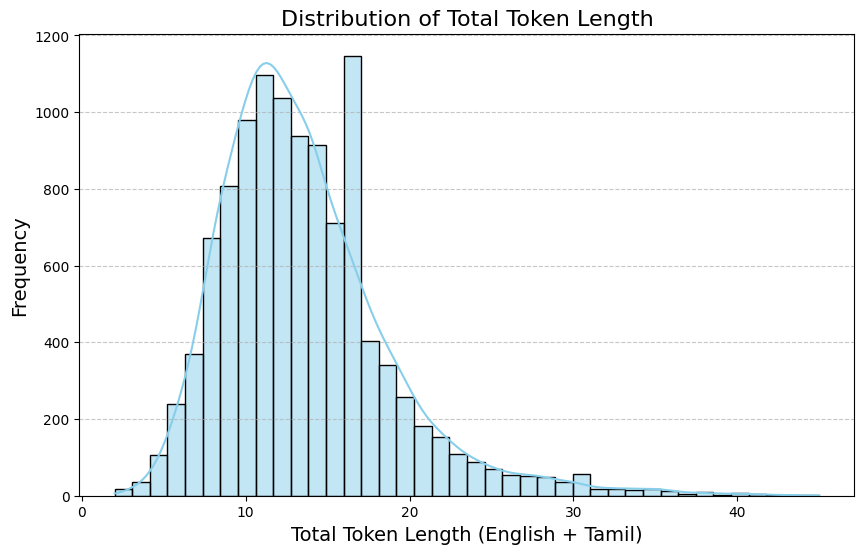

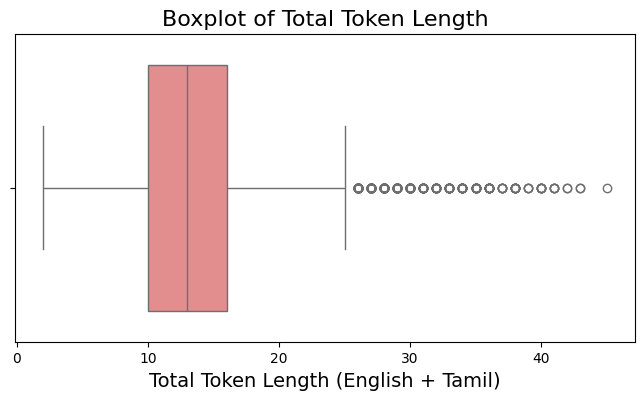

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of total token length using a histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_sorted["total_token_length"], bins=40, kde=True, color="skyblue")
plt.title("Distribution of Total Token Length", fontsize=16)
plt.xlabel("Total Token Length (English + Tamil)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Optional: Boxplot for a quick summary of the distribution
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_sorted["total_token_length"], color="lightcoral")
plt.title("Boxplot of Total Token Length", fontsize=16)
plt.xlabel("Total Token Length (English + Tamil)", fontsize=14)
plt.show()


In [48]:
import torch
from torch.utils.data import Dataset

class TranslationDataset(Dataset):
    def __init__(self, dataframe, pad_token=1):
        self.dataframe = dataframe
        self.pad_token = pad_token  # Padding value, typically 0

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get the tokenized sequences for English and Tamil
        english =  self.dataframe.iloc[idx]["English"]
        tamil =  self.dataframe.iloc[idx]["Tamil"]
        english_tokens =  torch.tensor(self.dataframe.iloc[idx]["Padded_English"],  dtype=torch.long)  # Shape: (T_english,)
        tamil_tokens = torch.tensor(self.dataframe.iloc[idx]["Padded_Tamil"],  dtype=torch.long)   # Shape: (T_tamil,)
        tamil_target_tokens = torch.tensor(self.dataframe.iloc[idx]["Padded_Tamil_Target"],  dtype=torch.long)   # Shape: (T_tamil_target,)


        def causal_mask(size):
              mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
              return mask == 0
    # Return the sequence and masks in a dictionary
        return {
            "english": english,
            "tamil": tamil,
            "english_token": english_tokens.clone(),
            "tamil_token": tamil_tokens.clone(),
            "tamil_target": tamil_target_tokens.clone(),
            "encoder_mask": (english_tokens != self.pad_token).unsqueeze(0).unsqueeze(0).int().clone(),
            "decoder_mask": (tamil_tokens != self.pad_token).unsqueeze(0).int() & causal_mask(tamil_tokens.size(0)).clone(),

        }

In [49]:
from torch.utils.data import DataLoader

# Assuming you have your Dataset class `TranslationDataset` and DataLoader defined
# Example DataLoader for your dataset
dataset1 = TranslationDataset(level1)  # Your dataframe should be defined
train_dataloader_1 = DataLoader(dataset1, batch_size = 32, shuffle=True)  # Set batch_size as needed  # Your dataframe should be defined
test_dataloader_1 = DataLoader(dataset1, batch_size=1, shuffle=True)  # Set batch_size as needed

dataset2 = TranslationDataset(level2)  # Your dataframe should be defined
train_dataloader_2 = DataLoader(dataset2, batch_size = 32, shuffle=True)  # Set batch_size as needed  # Your dataframe should be defined
test_dataloader_2 = DataLoader(dataset2, batch_size=1, shuffle=True)  # Set batch_size as needed

dataset3 = TranslationDataset(level3)  # Your dataframe should be defined
train_dataloader_3 = DataLoader(dataset3, batch_size = 32, shuffle=True)  # Set batch_size as needed  # Your dataframe should be defined
test_dataloader_3 = DataLoader(dataset3, batch_size=1, shuffle=True)  # Set batch_size as needed

dataset4 = TranslationDataset(hybrid)  # Your dataframe should be defined
train_dataloader_4 = DataLoader(dataset4, batch_size = 32, shuffle=True)  # Set batch_size as needed  # Your dataframe should be defined
test_dataloader_4 = DataLoader(dataset4, batch_size=1, shuffle=True)  # Set batch_size as needed
# Iterate through batches

for batch_idx, batch in enumerate(train_dataloader_3):
    print(f"Batch {batch_idx + 1}:")

    # Check the shapes of each tensor in the batch
    print(f"  English sequence shape: {batch['english'][0]}")  # Expected: (batch_size, T_english)
    print(f"  Tamil sequence shape: {batch['tamil'][0]}")  # Expected: (batch_size, T_tamil)
    print(f"  English token shape: {batch['english_token'][0]}")  # Expected: (batch_size, T_english)
    print(f"  tamil token shape: {batch['tamil_token'].shape}")  # Expected: (batch_size, T_english)
    print(f"  Tamil target sequence shape: {batch['tamil_target'][0]}")  # Expected: (batch_size, T_tamil_target)
    print(f"  English pad mask shape: {batch['encoder_mask'][0]}")  # Expected: (batch_size, T_english, T_english)
    print(f"  Combined Tamil mask shape: {batch['decoder_mask'][0]}")  # Expected: (batch_size, T_tamil_target, T_tamil_target)
    break
    
# Iterate through batches
for batch_idx, batch in enumerate(test_dataloader_3):
    print(f"Batch {batch_idx + 1}:")

    # Check the shapes of each tensor in the batch
    print(f"  English sequence shape: {batch['english'][0]}")  # Expected: (batch_size, T_english)
    print(f"  Tamil sequence shape: {batch['tamil'][0]}")  # Expected: (batch_size, T_tamil)
    print(f"  English token shape: {batch['english_token'][0]}")  # Expected: (batch_size, T_english)
    print(f"  tamil token shape: {batch['tamil_token'].shape}")  # Expected: (batch_size, T_english)
    print(f"  Tamil target sequence shape: {batch['tamil_target'][0]}")  # Expected: (batch_size, T_tamil_target)
    print(f"  English pad mask shape: {batch['encoder_mask'][0]}")  # Expected: (batch_size, T_english, T_english)
    print(f"  Combined Tamil mask shape: {batch['decoder_mask'][0]}")  # Expected: (batch_size, T_tamil_target, T_tamil_target)
    break


Batch 1:
  English sequence shape: No wonder you could not open the door
  Tamil sequence shape: நீங்கள் கதவை திறக்க முடியாமல் போனதில் ஆச்சரியமில்லை
  English token shape: tensor([   2,  168,  101,   83,  149,   96,  667,   50, 1045,    3,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1])
  tamil token shape: torch.Size([32, 24])
  Tamil target sequence shape: tensor([  52, 1332,  796, 5520, 5708, 5709,    3,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1])
  English pad mask shape: tensor([[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0]]], dtype=torch.int32)
  Combined Tamil mask shape: tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0],
         [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0],
         [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [50]:
print("Vocabulary:", len(tamil_tokenizer.word_to_id))
print("Vocabulary:", len(english_tokenizer.word_to_id))

Vocabulary: 15529
Vocabulary: 8100


In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

src_vocab_size = 8100
tgt_vocab_size = 15529
d_model = 64
n_heads = 8
d_ff = 512
n_enc_layers = 8
n_dec_layers = 8
dropout = 0.1

import torch
import torch.nn as nn
import math
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class MultiHeadSelfAttention(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model # Embedding vector size
        self.h = h # Number of heads
        # Make sure d_model is divisible by h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h # Dimension of vector seen by each head
        self.w_q = nn.Linear(d_model, d_model, bias=False) # Wq
        self.w_k = nn.Linear(d_model, d_model, bias=False) # Wk
        self.w_v = nn.Linear(d_model, d_model, bias=False) # Wv
        self.w_o = nn.Linear(d_model, d_model, bias=False) # Wo
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        # Just apply the formula from the paper
        # (batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            # Write a very low value (indicating -inf) to the positions where mask == 0
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1) # (batch, h, seq_len, seq_len) # Apply softmax
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        # (batch, h, seq_len, seq_len) --> (batch, h, seq_len, d_k)
        # return attention scores which can be used for visualization
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        key = self.w_k(k) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        value = self.w_v(v) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)

        # (batch, seq_len, d_model) --> (batch, seq_len, h, d_k) --> (batch, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        # Calculate attention
        x, self.attention_scores = MultiHeadSelfAttention.attention(query, key, value, mask, self.dropout)

        # Combine all the heads together
        # (batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k) --> (batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        # Multiply by Wo
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        return self.w_o(x)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))

class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.attn = MultiHeadSelfAttention(d_model, n_heads, dropout)
        self.ff = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.attn(x,x,x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadSelfAttention(d_model, n_heads, dropout)
        self.enc_attn = MultiHeadSelfAttention(d_model, n_heads, dropout)
        self.ff = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        self_attn_output = self.self_attn(x ,x, x, tgt_mask)
        x = self.norm1(x + self.dropout(self_attn_output))
        enc_attn_output = self.enc_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(enc_attn_output))
        ff_output = self.ff(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

class Encoder(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, d_ff, n_layers, dropout=0.1):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])

    def forward(self, src, src_mask):
        x = self.embedding(src)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, src_mask)
        return x

class Decoder(nn.Module):
    def __init__(self, output_dim, d_model, n_heads, d_ff, n_layers, dropout=0.1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.fc_out = nn.Linear(d_model, output_dim)

    def forward(self, tgt, enc_output, src_mask, tgt_mask):
        x = self.embedding(tgt)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, enc_output, src_mask, tgt_mask)

        return self.fc_out(x)

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, n_heads, d_ff, n_enc_layers, n_dec_layers, dropout=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(src_vocab_size, d_model, n_heads, d_ff, n_enc_layers, dropout)
        self.decoder = Decoder(tgt_vocab_size, d_model, n_heads, d_ff, n_dec_layers, dropout)

    def forward(self, src, tgt, src_mask, tgt_mask):
        enc_output = self.encoder(src, src_mask)
        output = self.decoder(tgt, enc_output, src_mask, tgt_mask)
        return output
    
model = Transformer(src_vocab_size, tgt_vocab_size, d_model, n_heads, d_ff, n_enc_layers, n_dec_layers, dropout).to(device)


Using device: cuda


In [52]:
from num2words import num2words

def number_to_words(num):
    # Convert number to words in Indian numbering system
    return num2words(num, lang='en_IN')

def count_parameters(model):
    return sum(p.numel() for p in model.parameters()) 
# Assuming 'model' is your PyTorch model

total_params = count_parameters(model)
print(f"Total model parameters: {total_params} -- {number_to_words(total_params)}") 

Total model parameters: 3977769 -- thirty-nine lakh, seventy-seven thousand, seven hundred and sixty-nine


In [57]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm
import os
from pathlib import Path
import warnings
from torch.utils.data import random_split
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace



epochs = 5
lr = 10**-4

def causal_mask(size):
    mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
    return mask == 0

def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    sos_idx, eos_idx = 2, 3
    encoder_output = model.encoder(source.to(device), source_mask.to(device))
    decoder_input = torch.empty(1, 1).fill_(sos_idx).type_as(source).to(device)

    while decoder_input.size(1) < max_len:
        decoder_mask = causal_mask(decoder_input.size(1)).type_as(source_mask).to(device)
        out = model.decoder(decoder_input, encoder_output, source_mask, decoder_mask)
        next_word = torch.max(out[:, -1], dim=1)[1]
        if next_word == eos_idx: break
        decoder_input = torch.cat([decoder_input, next_word.view(1, 1).to(device)], dim=1)
        #if next_word == eos_idx: break

    return decoder_input.squeeze(0)[1:]


def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, num_examples=1):
    model.to(device)
    model.eval()
    source_texts, expected, predicted = [], [], []
    try:
      console_width = os.get_terminal_size().columns
    except OSError:
      console_width = 80

    with torch.no_grad():
        for count, batch in enumerate(validation_ds, start=1):
            encoder_input, encoder_mask = batch["english_token"].to(device), batch["encoder_mask"].to(device)
            assert encoder_input.size(0) == 1, "Batch size must be 1 for validation"
            model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)

            source_text = batch["english"][0]
            target_text = batch["tamil"][0]
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy())

            source_texts.append(source_text)
            expected.append(target_text)
            predicted.append(model_out_text)

            print_msg(f"{'-'*console_width}\n{'SOURCE:':>12}{source_text}\n{'TARGET:':>12}{target_text}\n{'PREDICTED:':>12}{model_out_text}")
            if count == num_examples: break

def train_model():

    device = "cuda" if torch.cuda.is_available() else "mps" if torch.has_mps or torch.backends.mps.is_available() else "cpu"
    print("Using device:", device)
    if device == 'cuda':
        print(f"Device name: {torch.cuda.get_device_name(device.index)}")
        print(f"Device memory: {torch.cuda.get_device_properties(device.index).total_memory / 1024 ** 3} GB")

    checkpoint_path = "Model_Params.pth"
    if os.path.exists(checkpoint_path):
        model.load_state_dict(torch.load(checkpoint_path))
        print("Model loaded from checkpoint.")
    else :
        print("Checkpoint not found. Training from scratch.")

    
    optimizer = torch.optim.Adam(model.parameters(), lr = lr, eps=1e-9)
    loss_fn = nn.CrossEntropyLoss(ignore_index= 1).to(device)

    for epoch in range(epochs):
        torch.cuda.empty_cache()
        model.train()
        if epoch <= 5:
            print("Training with Level 1 Data")
            train_dataloader = train_dataloader_1
            test_dataloader = test_dataloader_1
        elif epoch > 5 and epoch <= 10:
            print("Training with Level 2 Data")
            train_dataloader = train_dataloader_2
            test_dataloader = test_dataloader_2
        elif epoch > 10: #and epoch <= 15:
            print("Training with Level 3 Data")
            train_dataloader = train_dataloader_3
            test_dataloader = test_dataloader_3
        else:
            print("cant get the data")

        batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch:02d}")
        for batch in batch_iterator:
            encoder_input = batch['english_token'].to(device)
            decoder_input = batch['tamil_token'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)
            decoder_mask = batch['decoder_mask'].to(device)

            output = model(encoder_input, decoder_input, encoder_mask, decoder_mask)

            label = batch['tamil_target'].to(device)

            loss = loss_fn(output.view(-1, (len(tamil_tokenizer.word_to_id))), label.view(-1))
            batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        torch.save(model.state_dict(), "Model_Params.pth")
        run_validation(model, test_dataloader, english_tokenizer, tamil_tokenizer, 24, device, lambda msg: batch_iterator.write(msg))

if __name__ == '__main__':
    warnings.filterwarnings("ignore")
    train_model()
      


Using device: cuda
Device name: NVIDIA GeForce GTX 1060 6GB
Device memory: 5.999755859375 GB
Model loaded from checkpoint.
Training with Level 1 Data


Processing Epoch 00: 100%|██████████| 110/110 [00:10<00:00, 10.29it/s, loss=1.620]


--------------------------------------------------------------------------------
     SOURCE:Did you tape that concert
     TARGET:நீங்கள் அந்த கச்சேரியை டேப் செய்தீர்களா
  PREDICTED:நீங்கள் அந்த கச்சேரியை டேப் செய்தீர்களா
Training with Level 1 Data


Processing Epoch 01: 100%|██████████| 110/110 [00:10<00:00, 10.61it/s, loss=1.654]


--------------------------------------------------------------------------------
     SOURCE:It is easy for me to swim
     TARGET:எனக்கு நீந்துவது எளிது
  PREDICTED:எனக்கு நீந்துவது எளிது
Training with Level 1 Data


Processing Epoch 02: 100%|██████████| 110/110 [00:10<00:00, 10.57it/s, loss=1.443]


--------------------------------------------------------------------------------
     SOURCE:We elected Mr Jordan chairperson
     TARGET:நாங்கள் திரு ஜோர்டான் தலைவரைத் தேர்ந்தெடுத்தோம்
  PREDICTED:நாங்கள் திரு நாங்கள் திரு நாங்கள் சென்றோம்
Training with Level 1 Data


Processing Epoch 03: 100%|██████████| 110/110 [00:10<00:00, 10.60it/s, loss=1.519]


--------------------------------------------------------------------------------
     SOURCE:Ive seen one many times
     TARGET:நான் பலமுறை பார்த்திருக்கிறேன்
  PREDICTED:நான் பலமுறை நான் ஒரு மீன்
Training with Level 1 Data


Processing Epoch 04: 100%|██████████| 110/110 [00:10<00:00, 10.52it/s, loss=1.710]


--------------------------------------------------------------------------------
     SOURCE:Foreign people intrigue me
     TARGET:வெளிநாட்டு மக்கள் என்னை கவர்ந்திழுக்கிறார்கள்
  PREDICTED:வெளிநாட்டு மக்கள் என்னை கவர்ந்திழுக்கிறார்கள்


In [ ]:
import torch
import os

def causal_mask(size, device):
    mask = torch.triu(torch.ones((1, size, size), device=device), diagonal=1).int()
    return mask == 0

def greedy_decode1(model, source, source_mask, max_len, device):
    sos_idx, eos_idx = 2, 3
    # Move encoder input to device
    encoder_output = model.encoder(source, source_mask)
    decoder_input = torch.empty(1, 1, device=device).fill_(sos_idx).long()

    while decoder_input.size(1) < max_len:
        decoder_mask = causal_mask(decoder_input.size(1), device)
        out = model.decoder(decoder_input, encoder_output, source_mask, decoder_mask)
        next_word = torch.max(out[:, -1], dim=1)[1]
        if next_word.item() == eos_idx:
            break
        decoder_input = torch.cat([decoder_input, next_word.view(1, 1)], dim=1)

    return decoder_input.squeeze(0)[1:]

def run_validation1(model, encoder_input, encoder_mask, max_len, device):
    model.to(device)
    model.eval()
    predicted = []
    
    try:
        console_width = os.get_terminal_size().columns
    except OSError:
        console_width = 80

    with torch.no_grad():
        # Ensure encoder input and mask are on the device
        encoder_input = encoder_input.to(device)
        encoder_mask = encoder_mask.to(device)
        
        assert encoder_input.size(0) == 1, "Batch size must be 1 for validation"
        model_out = greedy_decode1(model, encoder_input, encoder_mask, max_len, device)
    
        model_out_text = tamil_tokenizer.decode(model_out.detach().cpu().numpy())
        predicted.append(model_out_text)

        print(f"{'PREDICTED : '}{model_out_text}")

# Example sentence and pre-processing
sentence1 = "I am a good boy"
sentence = english_tokenizer.encode(sentence1)
sentence = pad_sequence_source(sentence, 20, cls_token=2, sep_token=3)
sentence = torch.tensor(sentence, dtype=torch.long).to('cuda')  # Move tensor to CUDA
encoder_input = sentence.unsqueeze(0).to('cuda')  # Ensure batch dimension and move to CUDA
encoder_mask = (sentence != 1).unsqueeze(0).unsqueeze(0).int().to('cuda')  # Move mask to CUDA

# Running validation on CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("SOURCE    :",sentence1)
run_validation1(model, encoder_input, encoder_mask, 24, device)


SOURCE    : I am a good boy
PREDICTED : நான் ஒரு நல்ல பையன்


In [78]:
import os

# Path to your checkpoint file
file_path = "Model_Params.pth"

# Check if the file exists
if os.path.exists(file_path):
    file_size = os.path.getsize(file_path)  # Size in bytes
    print(f"File size: {file_size / (1024 * 1024):.2f} MB")
else:
    print("File does not exist.")

File size: 17.71 MB
